## Ireland Covid-19 datasets

* https://data.gov.ie/dataset?q=covid&sort=score+desc%2C+metadata_created+desc
* https://www.hpsc.ie/a-z/respiratory/coronavirus/novelcoronavirus/casesinireland/epidemiologyofcovid-19inireland/
* https://covid19ireland-geohive.hub.arcgis.com/

In [27]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
import matplotlib.dates as mdates
sns.set_context('talk')
pd.set_option('display.width', 150)
locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
import geopandas as gpd

## LaboratoryLocalTimeSeriesHistoricView

In [189]:
labs = pd.read_csv('http://opendata-geohive.hub.arcgis.com/datasets/f6d6332820ca466999dbd852f6ad4d5a_0.csv?outSR={%22latestWkid%22:3857,%22wkid%22:102100}')
labs['date'] = pd.to_datetime(labs['Date_HPSC'], infer_datetime_format=True)
labs['Pos24'] = labs.Positive.diff()
#labs['Tests_diff'] = labs.TotalLabs.diff()
labs['rate'] = labs.Pos24/labs.Test24*100
labs[-10:]

,Date_HPSC,Hospitals,TotalLabs,NonHospitals,Positive,PRate,Test24,Test7,Pos7,PosR7,FID,date,Pos24,rate
237,2020/11/10 11:00:00+00,573016,1745725,1172709,69917,4.0,10406,78310,2923,3.7,238,2020-11-10 11:00:00,284.0,2.729195
238,2020/11/11 11:00:00+00,577695,1756512,1178817,70335,4.0,10787,76506,2724,3.6,239,2020-11-11 11:00:00,418.0,3.875035
239,2020/11/12 11:00:00+00,582801,1769569,1186768,70758,4.0,13057,77718,2697,3.5,240,2020-11-12 11:00:00,423.0,3.239642
240,2020/11/13 11:00:00+00,587321,1781179,1193858,71281,4.0,11610,77518,2718,3.5,241,2020-11-13 11:00:00,523.0,4.504737
241,2020/11/14 11:00:00+00,591087,1790980,1199893,71669,4.0,9801,75149,2678,3.6,242,2020-11-14 11:00:00,388.0,3.958780
242,2020/11/15 11:00:00+00,593931,1800164,1206233,72043,4.0,9184,74757,2737,3.7,243,2020-11-15 11:00:00,374.0,4.072300
243,2020/11/16 11:00:00+00,596853,1811270,1214417,72534,4.0,11106,75951,2901,3.8,244,2020-11-16 11:00:00,491.0,4.421034
244,2020/11/17 11:00:00+00,601064,1821244,1220180,72898,4.0,9974,75519,2981,3.9,245,2020-11-17 11:00:00,364.0,3.649489
245,2020/11/18 11:00:00+00,606326,1833804,1227478,73287,4.0,12560,77292,2952,3.8,246,2020-11-18 11:00:00,389.0,3.097134
246,2020/11/19 11:00:00+00,610974,1846444,1235470,73619,4.0,12640,76875,2861,3.7,247,2020-11-19 11:00:00,332.0,2.626582


In [163]:
labs[-90:]['Tests_diff'].mean()

12062.888888888889

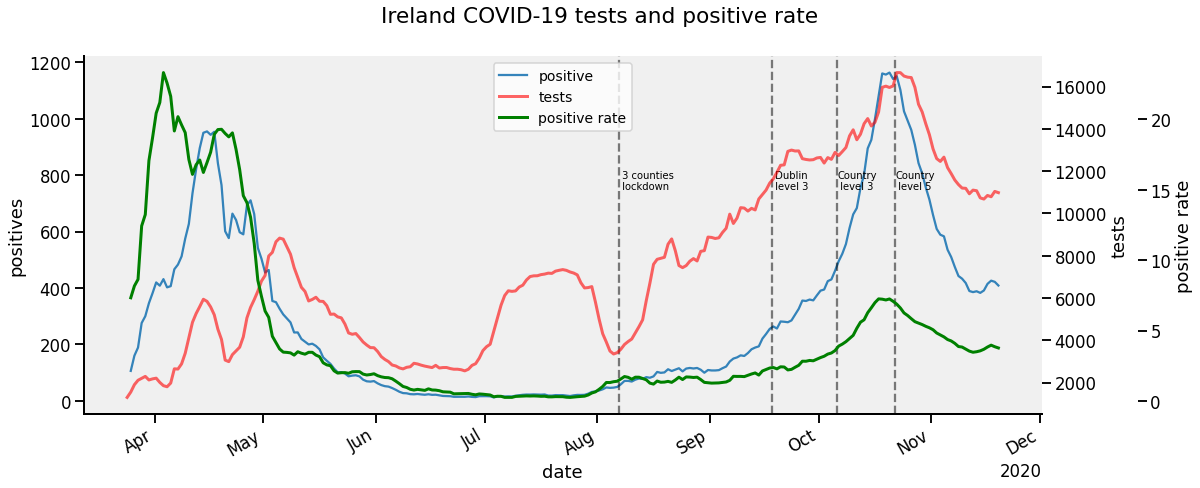

In [190]:
window=7
x=labs.set_index('date').rolling(window).mean()
#print (x[-10:])
x['false_pos'] = x.Test24*0.005

f,ax=plt.subplots(figsize=(17,7))
l1=x.plot(y='Pos24',ax=ax,legend=False,alpha=.9)
ax1=ax.twinx()
x.plot(y='Test24',ax=ax1,color='red',lw=3,legend=False,alpha=.6)
ax.set_ylabel('positives')
ax2=ax.twinx()
#ax2.axis('off')
ax1.set_ylabel('tests')
ax2.set_ylabel('positive rate')
ax2.spines["right"].set_position(("axes", 1.1))
ax.set_facecolor('#f0f0f0')
x.plot(y='rate',ax=ax2,color='green',lw=3,legend=False)
#error on positives based on 1% false positive rate in testing
#ax.fill_between(x.index, x.Positive_diff, x.Positive_diff-x.false_pos, alpha=0.3)
ax.legend([ax.get_lines()[0],ax1.get_lines()[0],ax2.get_lines()[0]],['positive','tests','positive rate'],loc=9,fontsize=14)
f.suptitle('Ireland COVID-19 tests and positive rate')

for date,text in [('2020-08-07',' 3 counties\n lockdown'),('2020-09-18',' Dublin\n level 3'),
                  ('2020-10-06','Country\n level 3'),('2020-10-22','Country\n level 5')]:
    ax.axvline(date,0,1000,linestyle='--',alpha=0.5,c='black')
    ax.text(date,750,text,fontsize=10)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
sns.despine()
plt.tight_layout()
f.savefig('ireland_covid_tests_prate.jpg',dpi=150)

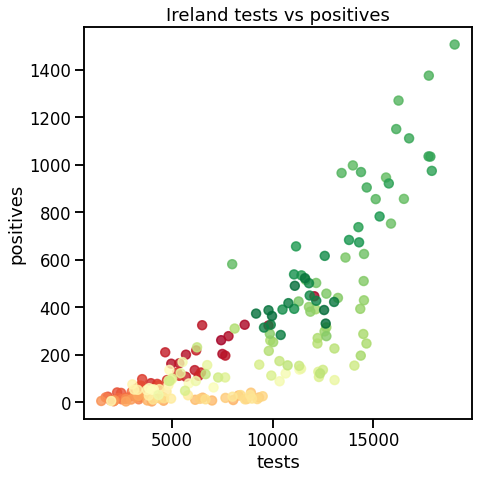

In [191]:
def plot_scatter(ax,i=10000):
    x = labs[(labs.date>'2020-05-01')]
    sc = x[:i].plot('Test24','Pos24',kind='scatter',cmap='RdYlGn',
                    alpha=0.8,s=80,ax=ax,c='date')
    ax.set_xlabel('tests')
    ax.set_ylabel('positives')
   # ax.set_xlim((0,max(labs.Tests_diff.dropna())))
    #ax.set_ylim((-100,1600))
    ax.set_title('Ireland tests vs positives')
    plt.tight_layout()
    plt.savefig('ireland_covid_tests_v_positives.jpg',dpi=120)
    
fig,ax=plt.subplots(1,1,figsize=(7,7))
plot_scatter(ax)

In [ ]:
import panel as pn
import panel.widgets as pnw
pn.extension()
plot_pane = pn.pane.Matplotlib()
plot_pane

In [82]:
plot_pane.object = fig
for i in range(len(labs)):
    ax.clear()
    plot_scatter(ax,i)     
    plot_pane.param.trigger('object')     


<Figure size 432x288 with 0 Axes>

## day of week testing

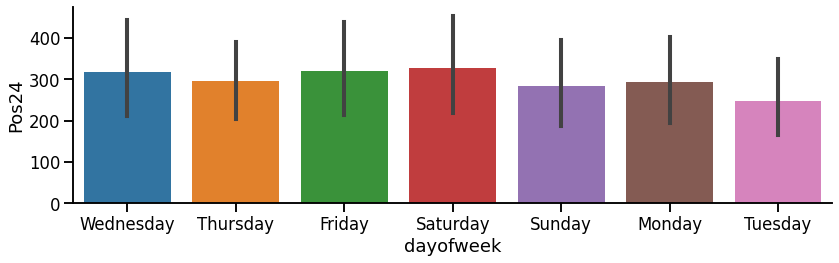

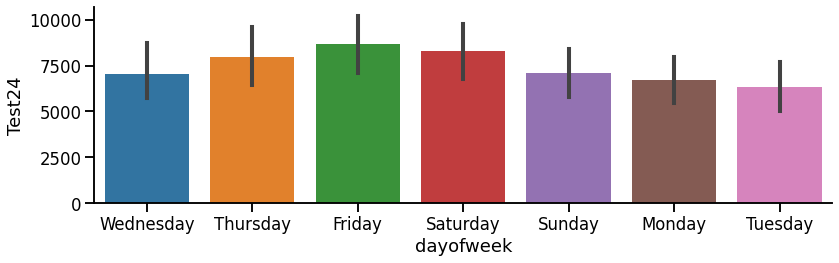

In [198]:
labs['dayofweek'] = labs.date.dt.day_name()
#labs.groupby('dayofweek').agg({'Tests_diff':np.mean})
sns.factorplot(x='dayofweek',y='Pos24',data=labs,kind='bar',aspect=3,size=4)
sns.factorplot(x='dayofweek',y='Test24',data=labs,kind='bar',aspect=3,size=4)

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


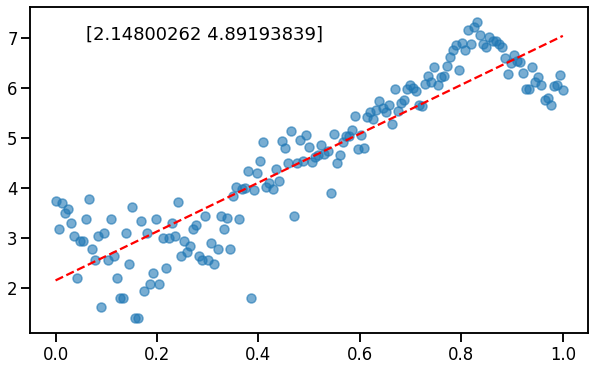

In [14]:
def fit_cases(y):
    from scipy.optimize import curve_fit 
    x = np.linspace(0, 1, num = len(y)) 
    #x = range(len(y))
    def func0(x, a, b): 
        return a+b*x
    def func1(x, a, b): 
        return a+np.exp(b*x)

    param, param_cov = curve_fit(func0, x, y) 
    f0 = func0(x,param[0],param[1])
    #param, param_cov = curve_fit(func1, x, y) 
    #f1 = func1(x,param[0],param[1])
    #print (param)

    f,ax=plt.subplots(figsize=(10,6))
    plt.scatter(x,y,alpha=0.6)
    plt.plot(x,f0,'--', color ='red')
    #plt.plot(x,f1,'--', color ='green',lw=4)
    plt.text(.1,.9,param,transform=ax.transAxes)
    
y = labs[(labs.date>'2020-06-01')].Positive_diff
y = np.log(y)
fit_cases(y)


## Covid19CountyStatisticsHPSCIrelandOpenData

In [18]:
cs = pd.read_csv('https://opendata.arcgis.com/datasets/d9be85b30d7748b5b7c09450b8aede63_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D')
cs['time'] = pd.to_datetime(cs['TimeStamp'], infer_datetime_format=True)
cs = cs.sort_values(['CountyName','time'])
cs.columns

Index(['OBJECTID', 'ORIGID', 'CountyName', 'PopulationCensus16', 'TimeStamp', 'IGEasting', 'IGNorthing', 'Lat', 'Long', 'UGI', 'ConfirmedCovidCases',
       'PopulationProportionCovidCases', 'ConfirmedCovidDeaths', 'ConfirmedCovidRecovered', 'Shape__Area', 'Shape__Length', 'time'],
      dtype='object')

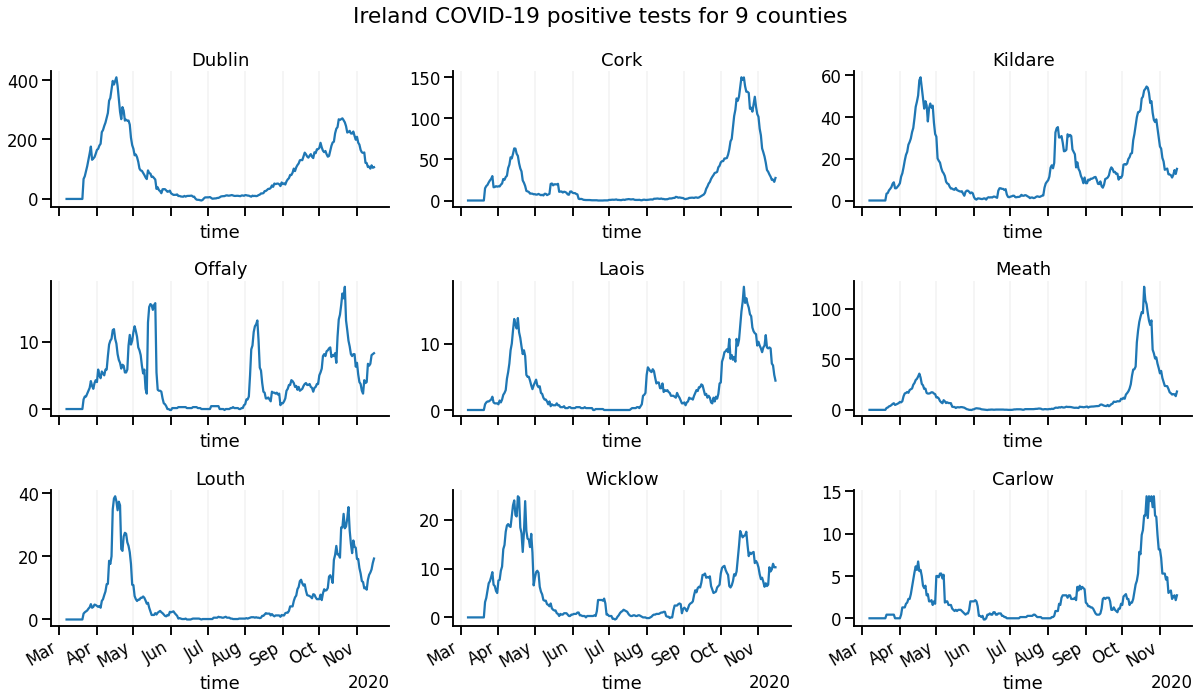

In [84]:
x=cs.set_index('time').rolling(window).mean()
f,ax=plt.subplots(3,3,figsize=(17,10))
axs=ax.flat
grouped = cs.groupby('CountyName')
i=0
for c in ['Dublin','Cork','Kildare','Offaly','Laois','Meath','Louth','Wicklow','Carlow']:
    ax=axs[i]
    x = cs[cs.CountyName==c].set_index('time').rolling(window).mean()
    x['cases'] = x['ConfirmedCovidCases'].diff() 
    x.plot(y='cases',ax=ax,legend=False)
    ax.set_title(c)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(axis='x',color='0.95')
    #ax1=ax.twinx()
    x.plot(y='ConfirmedCovidDeaths',ax=ax1,legend=False,color='red')
    if i>5:
        ax.xaxis.set_major_formatter(formatter)
    else:
        ax.set_xticklabels([])
    i+=1
sns.despine()
f.suptitle('Ireland COVID-19 positive tests for 9 counties')
plt.tight_layout()
f.savefig('ireland_covid_tests_bycounty.jpg',dpi=150)


## single counties plot

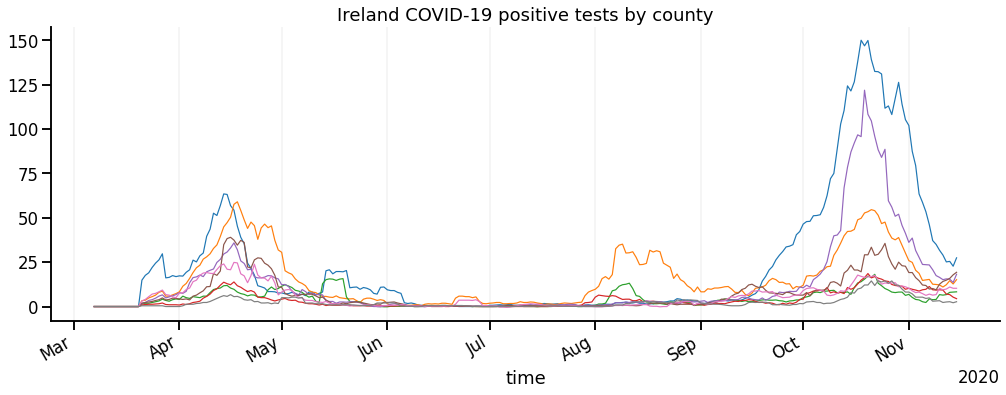

In [85]:
f,ax=plt.subplots(1,1,figsize=(17,6))
colors=sns.color_palette()
counties = cs.CountyName.unique()
selection = ['Dublin','Cork','Kildare','Offaly','Laois','Meath','Louth','Wicklow','Carlow']
i=0
lines=[]
for c in selection:
    x = cs[cs.CountyName==c].set_index('time').rolling(window).mean()
    x['cases'] = x['ConfirmedCovidCases'].diff()
    if c == 'Dublin':
        continue
    if c in selection:
        clr=colors[i]
        i+=1
    else:
        clr='#d0d0e1'
    a=x.plot(y='cases',ax=ax,legend=False,c=clr,lw=1.2)    
    
ax.set_title('Ireland COVID-19 positive tests by county')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.grid(axis='x',color='0.95')
#ax.legend(lines,selection,loc=9,fontsize=14)

sns.despine()


## CovidStatisticsProfileHPSCIrelandOpenData

In [86]:
daily = pd.read_csv('http://opendata-geohive.hub.arcgis.com/datasets/d8eb52d56273413b84b0187a4e9117be_0.csv?outSR={"latestWkid":3857,"wkid":102100}')
daily['date'] = pd.to_datetime(daily['Date'], infer_datetime_format=True)
daily['hospitalised_diff'] = daily.HospitalisedCovidCases.diff()

In [117]:
ds = daily#.groupby('date').sum().reset_index()

In [118]:
cols=['date','ConfirmedCovidCases','HospitalisedCovidCases','hospitalised_diff','ConfirmedCovidDeaths']
x=ds[cols]
x = x[(x.date>'2020-04-30')]

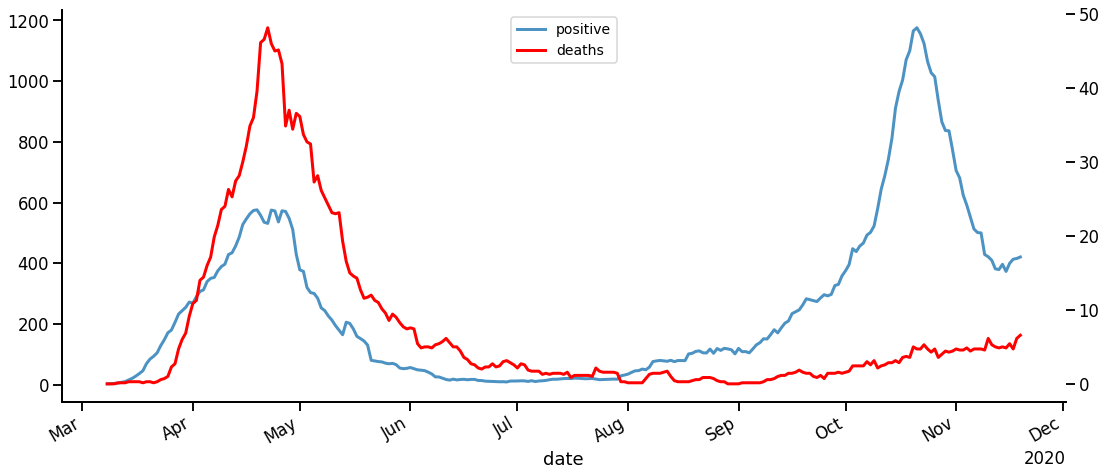

In [130]:
x=ds.set_index('date').rolling(window).mean()
f,ax=plt.subplots(1,1,figsize=(18,8))
ax1=ax.twinx()
x.plot(y='ConfirmedCovidCases',ax=ax,lw=3,legend=False,alpha=0.8)
#ds.plot(x='date',y='hospitalised_diff',ax=ax1,lw=3,legend=False,color='green')
x.plot(y='ConfirmedCovidDeaths',ax=ax1,lw=3,legend=False,color='red')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend([ax.get_lines()[0],ax1.get_lines()[0]],['positive','deaths'],loc=9,fontsize=14)
sns.despine()
plt.savefig('ireland_covid_deaths_tests.jpg',dpi=150)

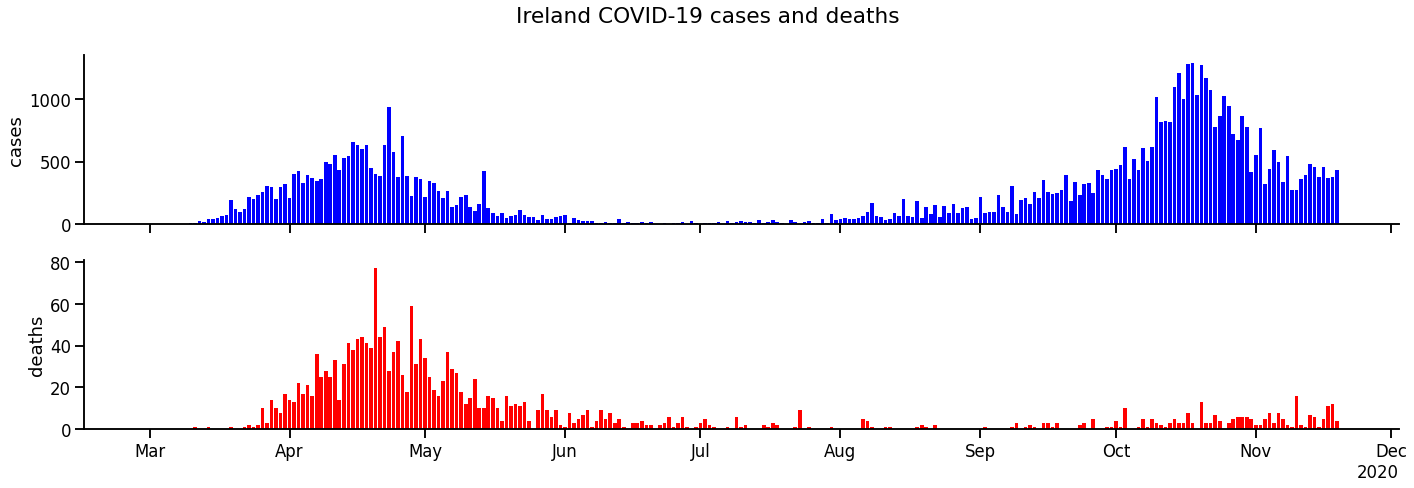

In [89]:
f,axs=plt.subplots(2,1,figsize=(20,7))
ax1=axs[0]
#ds.plot(x='date',y='ConfirmedCovidCases',ax=ax1,lw=2,legend=False,alpha=0.8,kind='bar')
ax1.bar(ds.date, ds.ConfirmedCovidCases,color='blue',width=.8)
ax1.set_ylabel('cases')
ax1.xaxis.set_ticklabels([])

ax2=axs[1]
#ds.plot(x='date',y='hospitalised_diff',ax=ax1,lw=3,legend=False,color='green')
#ds.plot(x='date',y='ConfirmedCovidDeaths',ax=ax2,legend=False,color='red',kind='bar')
ax2.bar(ds.date, ds.ConfirmedCovidDeaths,color='red')
ax2.set_ylabel('deaths')
ax2.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)

#ax.legend([ax.get_lines()[0],ax1.get_lines()[0],ax2.get_lines()[0]],['confirmed cases','hospitalised','deaths'],loc=1,fontsize=14)
f.suptitle('Ireland COVID-19 cases and deaths')
plt.tight_layout()
sns.despine()
f.savefig('ireland_covid_hosp_deaths.jpg',dpi=150)

In [172]:
hosp = pd.read_csv('http://opendata-geohive.hub.arcgis.com/datasets/fe9bb23592ec4142a4f4c2c9bd32f749_0.csv?outSR={%22latestWkid%22:4326,%22wkid%22:4326}')

In [173]:
idf = gpd.read_file('map_data/Covid19CountyStatisticsHPSCIreland.shp')

In [174]:
time='2020-02-27'
g=idf[idf.TimeStamp==time]

In [ ]:
fig, ax = plt.subplots(1, figsize=(9,9))
g.plot(column='Population', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.2',legend=True)
ax.axis('off')